In [1]:
from FlowStorm.flow_surface import FlowSurface
from FlowStorm.toy_data import generate_discrete_dataset, generate_snowstorm_dataset
from FlowStorm.clusters import make_snowstorm_anchors_density, make_uniform_grid_anchors_density
from FlowStorm.yield_model import YieldModel_RBF, YieldModel_Poly, YieldModel_SmoothingSpline
import jax.random as jr
import jax.numpy as jnp
import numpy as onp

import matplotlib.pyplot as plt

In [2]:
rng = jr.key(187)
N = 10_000_00
base_mu = 0.
base_sigma = 3.
baseline_data = generate_discrete_dataset(rng,base_mu,base_sigma,N)
base_alphas = jnp.array([base_mu]*N)

In [3]:
rng, subkey = jr.split(rng)
snowstorm_data, alphas = generate_snowstorm_dataset(subkey,N)

In [4]:
len(snowstorm_data), len(alphas)

(167072, 167072)

In [5]:
# anchors, yields = make_snowstorm_anchors_density(alphas,n_anchors=51)
anchors, yields = make_uniform_grid_anchors_density(alphas,n_anchors=30**2)

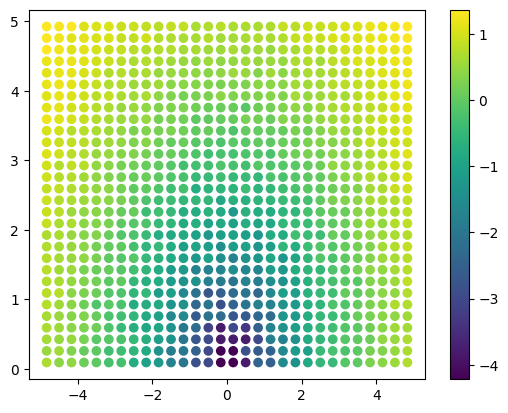

In [6]:
plt.scatter(anchors[:,0],anchors[:,1],c=yields)
plt.colorbar()

In [7]:
yld = YieldModel_SmoothingSpline(anchors,yields)

In [8]:
flow = FlowSurface(snowstorm_data, alphas)

In [9]:

flow.train_flow(learning_rate=1e-3)

 79%|███████▉  | 79/100 [01:13<00:19,  1.07it/s, train=2.38, val=2.37 (Max patience reached)]


In [13]:
%%timeit
base_alpha = [base_mu, base_sigma]
goal_alpha = [-1., 1.5]
yield_rate = yld.ratio(base_alpha, goal_alpha)

reweight = flow.get_weights(
    baseline_data,
    jnp.array(base_alpha),
    jnp.array(goal_alpha),
)
reweight *= yield_rate

336 ms ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


yield_rate used: 0.3118023630317387


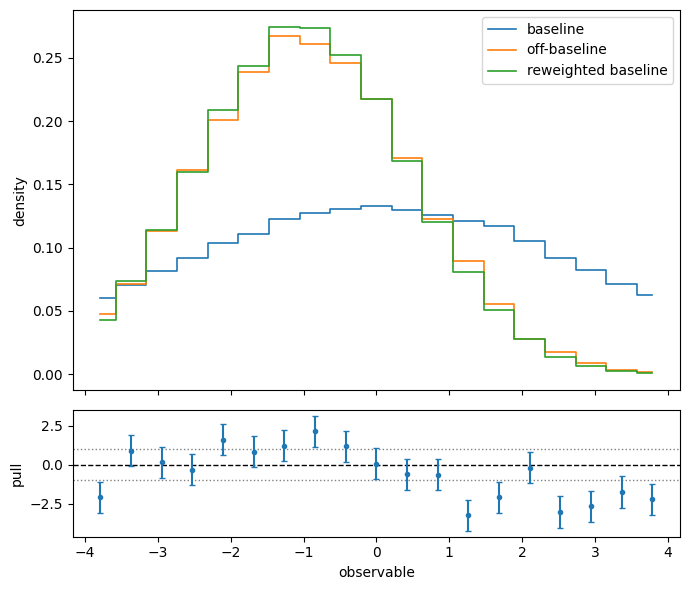

In [14]:
## Density only

base_alpha = [base_mu, base_sigma]
goal_alpha = [-1., 1.5]

rng = jr.key(12345653465)
rng, subkey = jr.split(rng)
off_set = generate_discrete_dataset(subkey, goal_alpha[0], goal_alpha[1], N)

yield_rate = yld.ratio(base_alpha, goal_alpha)
print("yield_rate used:", float(yield_rate))

reweight = flow.get_weights(
    baseline_data,
    jnp.array(base_alpha),
    jnp.array(goal_alpha),
)
# for density-only shape comparison, DO NOT apply yield_rate
# reweight *= yield_rate

# convert to numpy
baseline = onp.asarray(baseline_data)[:, 0]
off = onp.asarray(off_set).squeeze()
weights = onp.asarray(reweight)

bins = onp.linspace(-4, 4, 20)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_widths = bins[1:] - bins[:-1]

# --- density histograms ---
# density = counts / (N * bin_width)
h_base_cnt, _ = onp.histogram(baseline, bins=bins)
h_off_cnt,  _ = onp.histogram(off,      bins=bins)
h_rew_cnt,  _ = onp.histogram(baseline, bins=bins, weights=weights)

N_base = len(baseline)
N_off  = len(off)
sumw   = weights.sum()

h_base = h_base_cnt / (N_base * bin_widths)
h_off  = h_off_cnt  / (N_off  * bin_widths)
h_rew  = h_rew_cnt  / (sumw   * bin_widths)

# --- uncertainties on densities ---
# off: Poisson counts -> density error
sigma_off_cnt = onp.sqrt(h_off_cnt)
sigma_off = sigma_off_cnt / (N_off * bin_widths)

# reweighted: sqrt(sum w^2) counts -> density error
h_rew_w2, _ = onp.histogram(baseline, bins=bins, weights=weights**2)
sigma_rew_cnt = onp.sqrt(h_rew_w2)
sigma_rew = sigma_rew_cnt / (sumw * bin_widths)

# --- pulls in density space ---
den = onp.sqrt(sigma_rew**2 + sigma_off**2)
mask = den > 0
pulls = (h_rew - h_off) / den

# figure
fig, (ax, ax_res) = plt.subplots(
    2, 1, figsize=(7, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# main panel (densities)
ax.step(bin_centers, h_base, where="mid", label="baseline", lw=1.2)
ax.step(bin_centers, h_off,  where="mid", label="off-baseline", lw=1.2)
ax.step(bin_centers, h_rew,  where="mid", label="reweighted baseline", lw=1.2)

ax.set_ylabel("density")
ax.legend()

# pull panel
ax_res.axhline(0.0, ls="--", lw=1, color="k")
ax_res.axhline(1.0, ls=":", lw=1, color="gray")
ax_res.axhline(-1.0, ls=":", lw=1, color="gray")

ax_res.errorbar(
    bin_centers[mask],
    pulls[mask],
    yerr=onp.ones_like(pulls[mask]),  # pulls ~ unit variance
    fmt="o",
    markersize=3,
    capsize=2,
)

ax_res.set_xlabel("observable")
ax_res.set_ylabel("pull")

plt.tight_layout()
plt.show()

yield_rate used: 0.3118023630317387


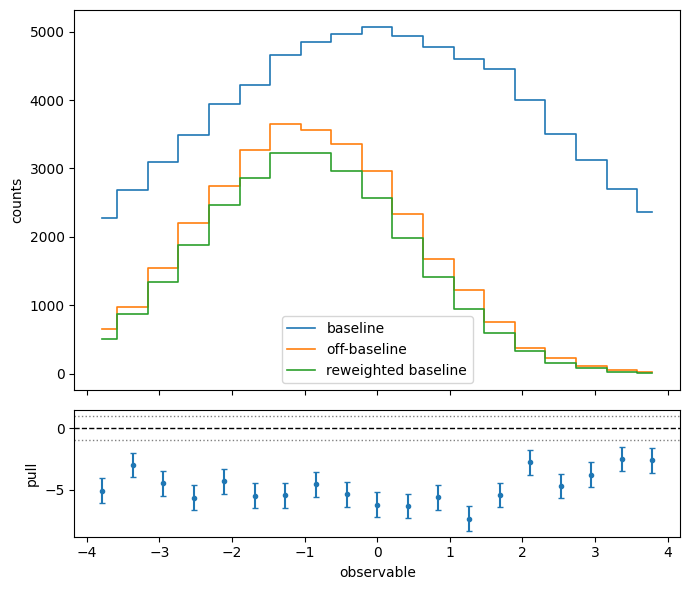

In [15]:
base_alpha = [base_mu, base_sigma]
goal_alpha = [-1., 1.5]

rng = jr.key(12345653465)
rng, subkey = jr.split(rng)
off_set = generate_discrete_dataset(subkey, goal_alpha[0], goal_alpha[1], N)

#yld = YieldModel_RBF(anchors, yields)
yield_rate = yld.ratio(base_alpha, goal_alpha)
print("yield_rate used:", float(yield_rate))

reweight = flow.get_weights(
    baseline_data,
    jnp.array(base_alpha),
    jnp.array(goal_alpha),
)
reweight *= yield_rate

# convert to numpy
baseline = onp.asarray(baseline_data)[:, 0]
off = onp.asarray(off_set).squeeze()
weights = onp.asarray(reweight)

bins = onp.linspace(-4, 4, 20)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# histograms (COUNTS)
h_base, _ = onp.histogram(baseline, bins=bins)
h_rew, _  = onp.histogram(baseline, bins=bins, weights=weights)
h_off, _  = onp.histogram(off, bins=bins)

# --- uncertainties ---
# off: Poisson
sigma_off = onp.sqrt(h_off)

# reweighted: sqrt(sum w^2)
h_rew_w2, _ = onp.histogram(baseline, bins=bins, weights=weights**2)
sigma_rew = onp.sqrt(h_rew_w2)

# --- pulls ---
# pull = (rew - off) / sqrt(sigma_rew^2 + sigma_off^2)
den = onp.sqrt(sigma_rew**2 + sigma_off**2)
mask = den > 0

pulls = (h_rew - h_off) / den

# figure
fig, (ax, ax_res) = plt.subplots(
    2, 1, figsize=(7, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# main panel
ax.step(bin_centers, h_base, where="mid", label="baseline", lw=1.2)
ax.step(bin_centers, h_off, where="mid", label="off-baseline", lw=1.2)
ax.step(bin_centers, h_rew, where="mid", label="reweighted baseline", lw=1.2)

ax.set_ylabel("counts")
ax.legend()

# pull panel
ax_res.axhline(0.0, ls="--", lw=1, color="k")
ax_res.axhline(1.0, ls=":", lw=1, color="gray")
ax_res.axhline(-1.0, ls=":", lw=1, color="gray")

ax_res.errorbar(
    bin_centers[mask],
    pulls[mask],
    yerr=onp.ones_like(pulls[mask]),  # pulls have unit variance
    fmt="o",
    markersize=3,
    capsize=2,
)

ax_res.set_xlabel("observable")
ax_res.set_ylabel("pull")
#ax_res.set_ylim(-5, 5)

plt.tight_layout()
plt.show()

In [42]:
%%timeit
yield_rate = yld.ratio(base_alpha, goal_alpha)

reweight = flow.get_weights(
    baseline_data,
    jnp.array(base_alpha),
    jnp.array(goal_alpha),
)
reweight *= yield_rate

482 ms ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:

print("sum weights:", float(h_rew.sum()))
print("N_off:", h_off.sum())
print("sum weights:", h_base.sum()/h_off.sum())
print("yield_rate used:", float(yield_rate**-1))

sum weights: 27463.98828125
N_off: 31735
sum weights: 2.322672128564676
yield_rate used: 3.2071597863362213


In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# accepted alphas from SnowStorm
A_acc = np.asarray(alphas)               # (N,2) accepted-only

# reference alphas from the known uniform box
Nref = len(A_acc)
rng = np.random.default_rng(0)
mu_ref = rng.uniform(-2.5, 2.5, size=Nref)
sig_ref = rng.uniform(0.1, 1.1, size=Nref)
A_ref = np.stack([mu_ref, sig_ref], axis=1)

# dataset for classifier
X = np.vstack([A_acc, A_ref])
y = np.hstack([np.ones(len(A_acc)), np.zeros(len(A_ref))])

# standardize
mean = X.mean(axis=0, keepdims=True)
std  = X.std(axis=0, keepdims=True) + 1e-12
Xz = (X - mean) / std

clf = LogisticRegression(max_iter=500)
clf.fit(Xz, y)

def yield_ratio_clf(base_alpha, goal_alpha):
    B = (np.asarray(base_alpha)[None,:] - mean) / std
    G = (np.asarray(goal_alpha)[None,:] - mean) / std
    sb = clf.predict_proba(B)[0,1]
    sg = clf.predict_proba(G)[0,1]
    # odds ratio
    return float((sg/(1-sg)) / (sb/(1-sb)))

base_alpha = [0.0, 1.0]
goal_alpha = [0.0, 0.5]
print("True ratio:", 0.25)
print("Classifier ratio:", yield_ratio_clf(base_alpha, goal_alpha))

True ratio: 0.25
Classifier ratio: 0.7889368700745727


In [29]:
h_off.sum()/h_rew.sum(), yield_rate**-1

(np.float64(0.9709770353633532), np.float64(2.6949915490259735))

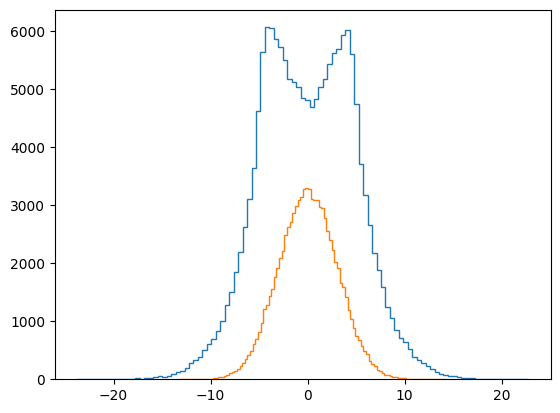

In [31]:
plt.hist(snowstorm_data,bins=101,histtype="step")
plt.hist(baseline,bins=101,histtype="step")
pass

In [11]:
snowstorm_data

Array([[-9.732139 ],
       [-8.210382 ],
       [-9.397733 ],
       ...,
       [-7.038233 ],
       [-9.187769 ],
       [-6.4417562]], dtype=float32)